In [1]:
# General Import Statements
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, RNN, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np


# tf.keras.backend.clear_session()

In [2]:
def clipped_relu(x):

    return tf.keras.activations.relu(x, max_value=20.0)

def clipped_sigmoid(x):

    return tf.keras.activations.sigmoid(x) * 10.0

In [3]:
import tensorflow.keras as keras
@keras.utils.register_keras_serializable(package="Custom", name="LTCCell")
class LTCCell(Layer):

    def __init__(self, units, ode_unfolds=6, l2_reg=0.001, **kwargs):

        super(LTCCell, self).__init__(**kwargs)

        self.units = units

        self.ode_unfolds = ode_unfolds

        self.state_size = units

        self.l2_reg = l2_reg  # L2 regularization parameter



    def build(self, input_shape):

        self.input_dim = input_shape[-1]
        # Trainable parameters with L2 regularization

        self.W = self.add_weight(

            shape=(self.input_dim + self.units, self.units),

            initializer='glorot_uniform',

            regularizer=l2(self.l2_reg),

            name='W'

        )

        self.bias = self.add_weight(

            shape=(self.units,),

            initializer='zeros',

            name='bias'

        )

        self.tau = self.add_weight(

            shape=(self.units,),

            initializer='ones',

            name='tau'

        )

        # Additional parameters for the LTC model

        self.C = self.add_weight(

            shape=(self.units,),

            initializer='ones',

            name='C'

        )

        self.G = self.add_weight(

            shape=(self.units,),

            initializer='ones',

            name='G'

        )

        super(LTCCell, self).build(input_shape)

    def call(self, inputs, states):

        prev_state = states[0]

        concatenated = tf.concat([inputs, prev_state], axis=1)

        dt = 0.01  # Time step

        for _ in range(self.ode_unfolds):

            dh = (-prev_state + tf.nn.tanh(tf.matmul(concatenated, self.W) + self.bias)) / tf.nn.softplus(self.tau)

            prev_state += dt * dh

        # Apply custom activation functions

        prev_state = clipped_relu(prev_state)

        prev_state = prev_state * clipped_sigmoid(self.C)

        prev_state = prev_state / clipped_sigmoid(self.G)

        return prev_state, [prev_state]
    
    def get_config(self):
        
        config = super(LTCCell, self).get_config()
        
        config.update({"units": self.units})
        
        return config

In [5]:
input_dir = '/kaggle/input/lnn-dl-6' 

X_train = np.load(os.path.join(input_dir, 'X_train.npy'))
X_test = np.load(os.path.join(input_dir, 'X_test.npy'))
y_train = np.load(os.path.join(input_dir, 'y_train.npy'))
y_test = np.load(os.path.join(input_dir, 'y_test.npy'))
class_weight = np.load(os.path.join(input_dir, 'class_weights.npy'))

# Convert class weights to a dictionary
num_classes = 4
class_weight_dict = dict(enumerate(class_weight))

# Print shapes of the loaded arrays
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

# Reshape X_train and X_test to 2D
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

y_train_categorical = np.argmax(y_train, axis=1)
y_test_categorical = np.argmax(y_test, axis=1)

Shape of X_train: (14368, 998, 39)
Shape of X_test: (3592, 998, 39)
Shape of y_train: (14368, 4)
Shape of y_test: (3592, 4)


In [ ]:

# Define the models
# svm_model = SVC(kernel='linear', C=1.0, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Define the LSTM model
def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:

# Build the LSTM model
lstm_model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=4)

# Train the models
rf_model.fit(X_train_2d, y_train_categorical)
lr_model.fit(X_train_2d, y_train_categorical)

# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    # callbacks=[early_stopping]
)



In [ ]:
from tensorflow.keras.models import load_model
lnn_model = load_model('/kaggle/input/emotion_model_625/keras/default/1/emotion_model_625.h5', custom_objects={"LTCCell": LTCCell})

lnn_loss, lnn_accuracy = lnn_model.evaluate(X_test, y_test)

# Predict on the test set
# y_pred_svm = svm_model.predict(X_test_2d)
y_pred_rf = rf_model.predict(X_test_2d)
y_pred_lr = lr_model.predict(X_test_2d)
# y_pred_lnn = lnn_model.predict(X_test)

# Evaluate the models
# svm_accuracy = accuracy_score(y_test_categorical, y_pred_svm)
rf_accuracy = accuracy_score(y_test_categorical, y_pred_rf)
lr_accuracy = accuracy_score(y_test_categorical, y_pred_lr)
# lnn_accuracy = accuracy_score(X_test, y_pred_lnn)


# Evaluate the LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)

print(f"LSTM Accuracy: {lstm_accuracy}")
# print(f"SVM Accuracy: {svm_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Liquid Neural Networks Accuracy: {lnn_accuracy}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6258 - loss: 0.9099


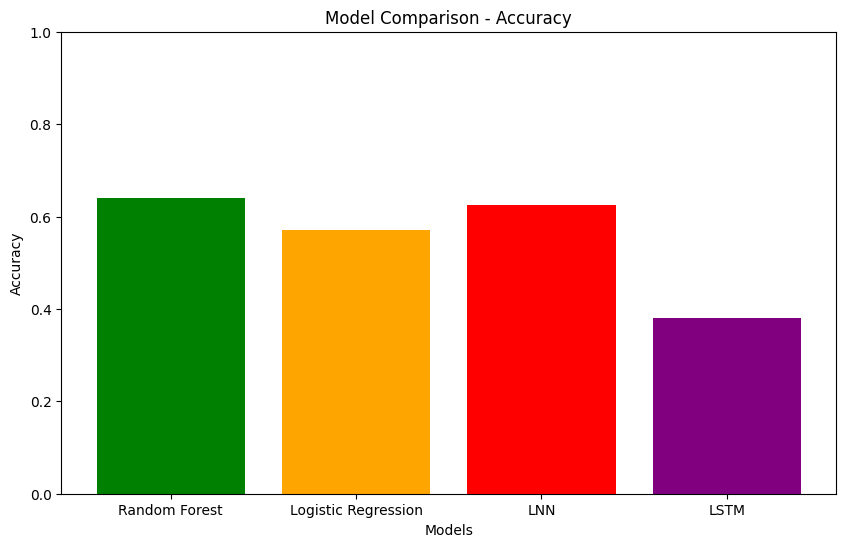

In [14]:


models = ['Random Forest', 'Logistic Regression', 'LNN', 'LSTM']
accuracies = [rf_accuracy, lr_accuracy, lnn_accuracy, lstm_accuracy]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['green', 'orange', 'red', 'purple'])
plt.title('Model Comparison - Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to match accuracy range
plt.show()